In [2]:
import numpy as np
import matplotlib.pyplot as plt
from flow_decomposition import FlowDecomposition
from flow_regression import FlowRegression, WeightedFlowRegression

Toy data preparation.

In [17]:


#############################################
# Test example using mixed Lorenz systems   #
#############################################

def simulate_lorenz(initial, sigma=10, rho=28, beta=8/3, dt=0.01, steps=1000):
    """
    Simulate a Lorenz attractor using Euler integration.
    Returns an array of shape (steps, 3).
    """
    trajectory = np.empty((steps, 3))
    trajectory[0] = initial
    for i in range(1, steps):
        x, y, z = trajectory[i-1]
        dx = sigma * (y - x)
        dy = x * (rho - z) - y
        dz = x * y - beta * z
        trajectory[i] = trajectory[i-1] + dt * np.array([dx, dy, dz])
    return trajectory

steps = 10000

# Simulate three independent Lorenz attractors.
traj1 = simulate_lorenz(initial=[1.0, 1.0, 1.0], steps=steps)
traj2 = simulate_lorenz(initial=[0.1, -1.0, 1.0], steps=steps)
traj3 = simulate_lorenz(initial=[0.5, 0.5, 0.0], steps=steps)

# Stack the three trajectories horizontally.
# This yields a latent data matrix of shape (steps, 9) [3 systems x 3 dimensions each].
X_latent = np.hstack([traj1, traj2, traj3])

M = np.random.randn(X_latent.shape[1], 20)  

# Mix the latent signals to generate the observed data.
X_mixed = X_latent @ M  # shape (steps, observed_dim)
X_mixed = (X_mixed - X_mixed.mean(axis=0))/X_mixed.std(axis=0)


`FlowDecomposition` usage example. Decomposition of mixed Lorenz dynamics.

In [18]:

# Initialization parameters for FlowDecomposition.
init_params = {
    "input_dim": 20, 
    "proj_dim": 2,
    "n_components": 3,        
    "num_delays": 0,
    "delay_step": 0,
    "model": "linear",
    "subtract_autocorr": False,
    "device": "cpu",
    "data_device": "cpu",
    "optimizer": "Adagrad",
    "learning_rate": 0.1,
    "random_state": None
}

# Fit parameters.
fit_params = {
    "sample_size": 150,
    "library_size": 1000,
    "exclusion_rad": 20,
    "time_intv": 80,
    "num_epochs": 500,
    "num_rand_samples": 32,
    "batch_size": 32,
    "method": "knn",
    "nbrs_num": 16,
    "theta": 5,
    "beta": 0,
    "optim_policy": "range",
    "mask_size": None
}

fd = FlowDecomposition(**init_params)
fd.fit(X_mixed, **fit_params)

Epoch 1/500, Loss: 0.8967, ccm_loss: 0.8967, h_norm_loss: 0.8741
Epoch 2/500, Loss: 0.8998, ccm_loss: 0.8998, h_norm_loss: 0.7927
Epoch 3/500, Loss: 0.8857, ccm_loss: 0.8857, h_norm_loss: 0.8115
Epoch 4/500, Loss: 0.8709, ccm_loss: 0.8709, h_norm_loss: 0.8171
Epoch 5/500, Loss: 0.8381, ccm_loss: 0.8381, h_norm_loss: 0.8090
Epoch 6/500, Loss: 0.8054, ccm_loss: 0.8054, h_norm_loss: 0.8040
Epoch 7/500, Loss: 0.7469, ccm_loss: 0.7469, h_norm_loss: 0.8076
Epoch 8/500, Loss: 0.7009, ccm_loss: 0.7009, h_norm_loss: 0.8097
Epoch 9/500, Loss: 0.6558, ccm_loss: 0.6558, h_norm_loss: 0.8118
Epoch 10/500, Loss: 0.5336, ccm_loss: 0.5336, h_norm_loss: 0.8352
Epoch 11/500, Loss: 0.5849, ccm_loss: 0.5849, h_norm_loss: 0.8175
Epoch 12/500, Loss: 0.4564, ccm_loss: 0.4564, h_norm_loss: 0.8248
Epoch 13/500, Loss: 0.4069, ccm_loss: 0.4069, h_norm_loss: 0.8454
Epoch 14/500, Loss: 0.3698, ccm_loss: 0.3698, h_norm_loss: 0.8398
Epoch 15/500, Loss: 0.3340, ccm_loss: 0.3340, h_norm_loss: 0.8327
Epoch 16/500, Loss:

In [19]:
unmixed = fd.predict(X_mixed)

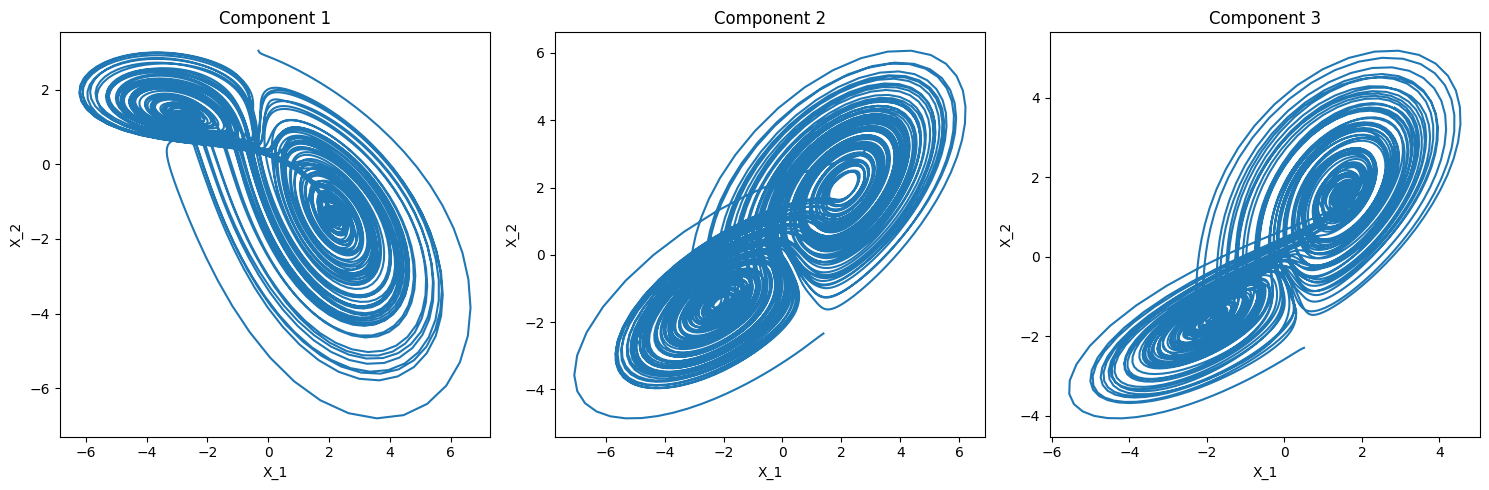

In [20]:

fig, axes = plt.subplots(nrows=1, ncols=unmixed.shape[1], figsize=(15, 5))
for i in range(unmixed.shape[1]):
    axes[i].plot(unmixed[:, i, 0], unmixed[:, i, 1])
    axes[i].set_title(f'Component {i+1}')
    axes[i].set_xlabel('X_1')
    axes[i].set_ylabel('X_2')
plt.tight_layout()
plt.show()

`FlowRegression` usage example. Projecting mixed Lorenz dynamics onto the space where they cross-map to one of the original Lorenz systems.

In [22]:

# Initialization parameters for FlowRegression.
init_params = {
    "input_dim": 20, 
    "proj_dim": 2,
    "num_delays": 3,
    "delay_step": 10,
    "model": "linear",
    "subtract_autocorr": False,
    "device": "cpu",
    "data_device": "cpu",
    "optimizer": "Adagrad",
    "learning_rate": 0.01,
    "random_state": None
}

# Fit parameters.
fit_params = {
    "sample_size": 150,
    "library_size": 1000,
    "exclusion_rad": 20,
    "time_intv": 80,
    "num_epochs": 500,
    "num_rand_samples": 32,
    "batch_size": 32,
    "method": "knn",
    "nbrs_num": 16,
    "theta": 5,
    "beta": 0,
    "optim_policy": "range"

}
y = traj1[:,:]

fd = FlowRegression(**init_params)
fd.fit(X=X_mixed, Y=y, **fit_params)

Epoch 1/500, Loss: 0.8469, ccm_loss: 0.8469, h_norm_loss: 0.8348
Epoch 2/500, Loss: 0.8209, ccm_loss: 0.8209, h_norm_loss: 0.8304
Epoch 3/500, Loss: 0.7981, ccm_loss: 0.7981, h_norm_loss: 0.8286
Epoch 4/500, Loss: 0.7563, ccm_loss: 0.7563, h_norm_loss: 0.8288
Epoch 5/500, Loss: 0.7129, ccm_loss: 0.7129, h_norm_loss: 0.8254
Epoch 6/500, Loss: 0.6781, ccm_loss: 0.6781, h_norm_loss: 0.8184
Epoch 7/500, Loss: 0.6489, ccm_loss: 0.6489, h_norm_loss: 0.8129
Epoch 8/500, Loss: 0.6062, ccm_loss: 0.6062, h_norm_loss: 0.8103
Epoch 9/500, Loss: 0.5801, ccm_loss: 0.5801, h_norm_loss: 0.8079
Epoch 10/500, Loss: 0.5493, ccm_loss: 0.5493, h_norm_loss: 0.8068
Epoch 11/500, Loss: 0.5240, ccm_loss: 0.5240, h_norm_loss: 0.8052
Epoch 12/500, Loss: 0.5021, ccm_loss: 0.5021, h_norm_loss: 0.8024
Epoch 13/500, Loss: 0.4737, ccm_loss: 0.4737, h_norm_loss: 0.7986
Epoch 14/500, Loss: 0.4538, ccm_loss: 0.4538, h_norm_loss: 0.7953
Epoch 15/500, Loss: 0.4332, ccm_loss: 0.4332, h_norm_loss: 0.7900
Epoch 16/500, Loss:

In [23]:
unmixed = fd.predict(X_mixed)

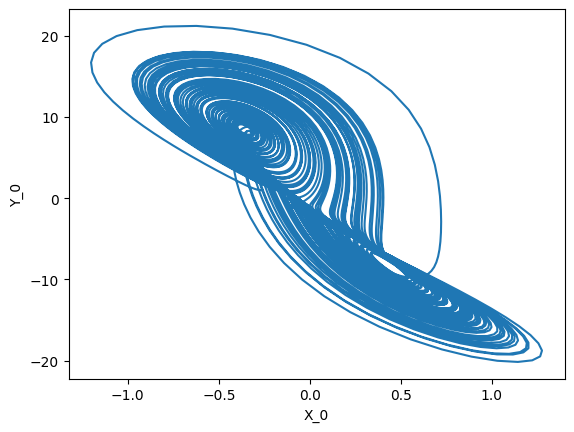

In [25]:
plt.plot(unmixed[:,0],y[:,0])
plt.xlabel('X_0')
plt.ylabel('Y_0')
plt.show()

`WeightedFlowRegression` usage example. Projecting mixed Lorenz dynamics onto the space where they cross-map to one of the original Lorenz systems.

In [9]:

# Initialization parameters for WeightedFlowRegression.
init_params = {
    "input_dim": 20, 
    "proj_dim": 2,
    "num_delays": 3,
    "delay_step": 10,
    "model": "linear",
    "subtract_autocorr": False,
    "device": "cpu",
    "data_device": "cpu",
    "optimizer": "Adagrad",
    "learning_rate": 0.01,
    "random_state": None
}

# Fit parameters.
fit_params = {
    "sample_size": 150,
    "library_size": 1000,
    "exclusion_rad": 20,
    "time_intv": 80,
    "num_epochs": 500,
    "num_rand_samples": 32,
    "batch_size": 32,
    "method": "knn",
    "nbrs_num": 16,
    "theta": 5,
    "beta": 0,
    "optim_policy": "range"

}
y = traj1[:,:]

fd = WeightedFlowRegression(**init_params)
fd.fit(X=X_mixed, Y=y, **fit_params)

Epoch 1/500, Loss: 0.8212, ccm_loss: 0.8212, h_norm_loss: 0.8014
Epoch 2/500, Loss: 0.7514, ccm_loss: 0.7514, h_norm_loss: 0.7955
Epoch 3/500, Loss: 0.6903, ccm_loss: 0.6903, h_norm_loss: 0.7993
Epoch 4/500, Loss: 0.6489, ccm_loss: 0.6489, h_norm_loss: 0.7961
Epoch 5/500, Loss: 0.6030, ccm_loss: 0.6030, h_norm_loss: 0.7985
Epoch 6/500, Loss: 0.5378, ccm_loss: 0.5378, h_norm_loss: 0.7993
Epoch 7/500, Loss: 0.4864, ccm_loss: 0.4864, h_norm_loss: 0.7996
Epoch 8/500, Loss: 0.4474, ccm_loss: 0.4474, h_norm_loss: 0.8026
Epoch 9/500, Loss: 0.4223, ccm_loss: 0.4223, h_norm_loss: 0.8033
Epoch 10/500, Loss: 0.3817, ccm_loss: 0.3817, h_norm_loss: 0.8045
Epoch 11/500, Loss: 0.3554, ccm_loss: 0.3554, h_norm_loss: 0.8062
Epoch 12/500, Loss: 0.3520, ccm_loss: 0.3520, h_norm_loss: 0.8100
Epoch 13/500, Loss: 0.3478, ccm_loss: 0.3478, h_norm_loss: 0.8124
Epoch 14/500, Loss: 0.3280, ccm_loss: 0.3280, h_norm_loss: 0.8154
Epoch 15/500, Loss: 0.2940, ccm_loss: 0.2940, h_norm_loss: 0.8176
Epoch 16/500, Loss:

In [10]:
unmixed = fd.predict(X_mixed)
weights = fd.predict_weights(X_mixed)

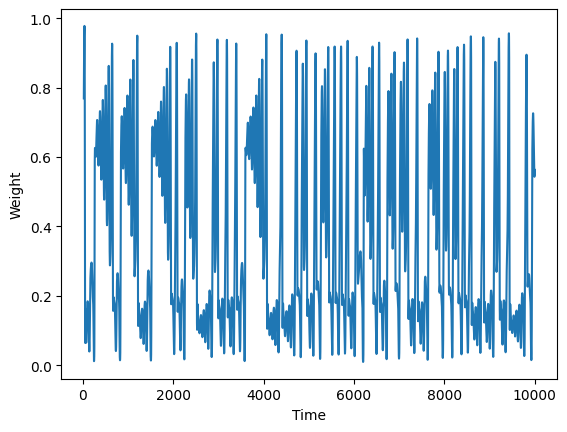

In [11]:
plt.plot(weights[:,0])
plt.xlabel('Time')
plt.ylabel('Weight')
plt.show()

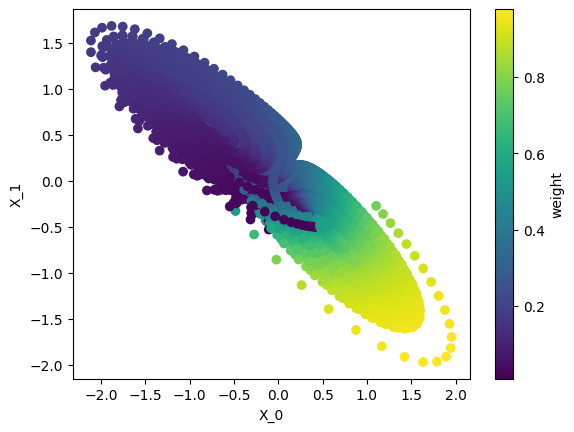

In [15]:
plt.scatter(unmixed[:,0],unmixed[:,1],c=weights[:,0])
plt.xlabel('X_0')
plt.ylabel('X_1')
plt.colorbar(label="weight")
plt.show()